In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.visualization import display_loss
from scripts.models.pytorch.train import train

from scripts.models.random_forest.random_forest import train_random_forest

from NIDS_attacks.substitut import attack_substitut
from NIDS_attacks.fgsm import attack

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    root_dir=root_dir,
    log_name="test_substitut",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")

2025-11-27 18:40:16,148 - INFO - Logger initialized for 'test_substitut_20251127_184016'


In [2]:
dataset = CICIDS2017(
    dataset_size="small",
    logger=logger
).optimize_memory().encode()

2025-11-27 18:40:16,156 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-27 18:40:16,682 - INFO - Loading dataset into DataFrame
2025-11-27 18:40:30,987 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-27 18:40:46,520 - INFO - Removed 1,147 rows with non-positive 'Flow Duration'. Remaining: 1,941,546
2025-11-27 18:40:47,435 - INFO - ============================================================
2025-11-27 18:40:47,436 - INFO - Preprocessing completed successfully
2025-11-27 18:40:47,437 - INFO - Final dimensions: 1,939,551 rows x 71 columns
2025-11-27 18:40:47,437 - INFO - Total rows removed: 274,918 (12.41%)
2025-11-27 18:40:47,438 - INFO - data retention rate: 87.59%
2025-11-27 18:40:47,438 - INFO - ============================================================
2025-11-27 18:40:47,439 - INFO - Optimizing memory usage of the dataset...
2025-11-27 18:40:47,443 - INFO - Initial memory usage: 1065.43 MB
2025-11-27 18:40:48,105 - INFO 

In [3]:
multi_class = False

X_train, X_test, y_train, y_test = dataset.subset(size=800*1000, multi_class=multi_class).split(
    one_hot=True,
    test_size=0.3,
    apply_smote=True
)

num_classes = y_train.shape[1]

2025-11-27 18:40:48,914 - INFO - Subsetting dataset to size: 800000...
2025-11-27 18:40:48,924 - INFO - Class distribution before subsetting:
2025-11-27 18:40:48,925 - INFO -   Class 0: 1527098 samples
2025-11-27 18:40:48,925 - INFO -   Class 1: 412453 samples
2025-11-27 18:40:49,018 - INFO - Subsetted dataset to size: 800000
2025-11-27 18:40:49,798 - INFO - Splitting dataset into training and testing sets...
2025-11-27 18:40:54,444 - INFO - Class distribution before SMOTE:
2025-11-27 18:40:54,444 - INFO -   Class 0.0: 279970 samples
2025-11-27 18:40:54,445 - INFO -   Class 1.0: 280030 samples
2025-11-27 18:40:54,448 - INFO - Class distribution after SMOTE:
2025-11-27 18:40:54,449 - INFO -   Class 0.0: 279970 samples
2025-11-27 18:40:54,449 - INFO -   Class 1.0: 280030 samples


Initialisation des données


In [4]:
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model, cv_scores = train_random_forest(
    X_train,
    y_train,
    n_estimators=10,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)

if cv_scores != None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-27 18:40:54,489 - INFO - Training Random Forest with cross-validation using train_random_forest...


Evaluation of the Random Forest Before attack

2025-11-27 18:41:18,664 - INFO - Running analysis for scikit-learn model: RandomForest before adversarial attack
2025-11-27 18:41:18,886 - INFO - AUC: 0.9970


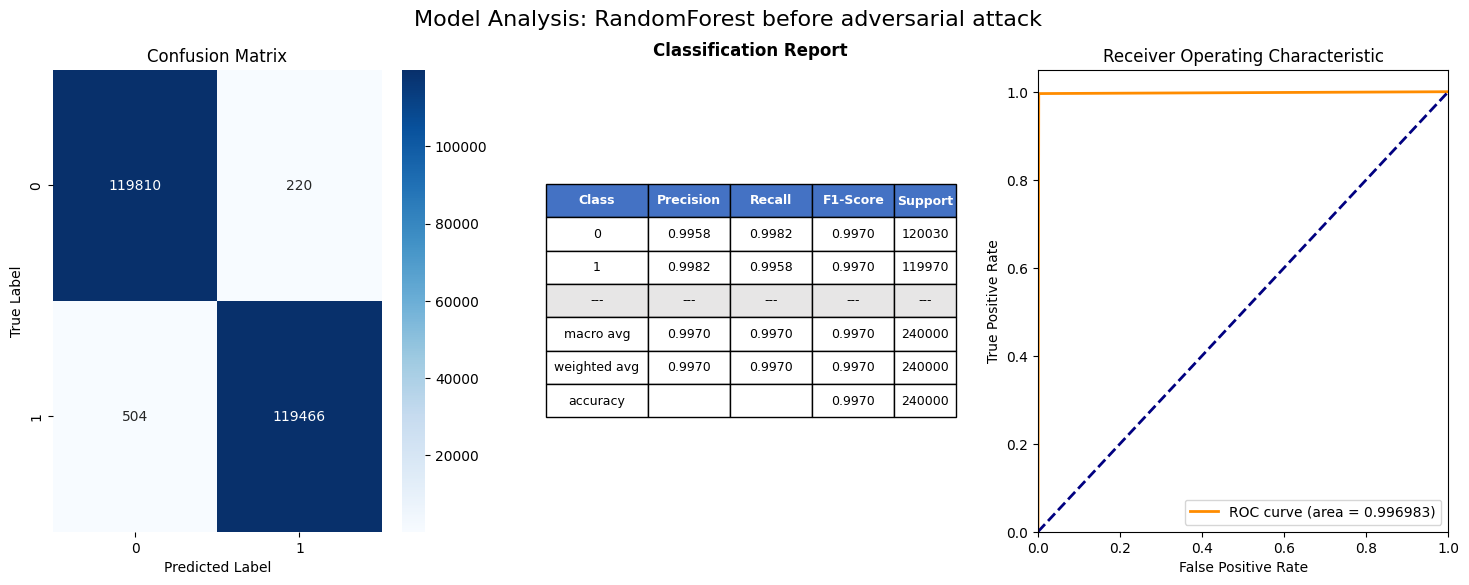

In [5]:
# Evaluate model
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    num_classes=num_classes,
    logger=logger,
    title="RandomForest before adversarial attack",
    root_dir=root_dir,
    plot=True
)

Generation of the substitut for the attack

2025-11-27 18:41:19,439 - INFO - Running analysis for scikit-learn model: RandomForest Substitut
Loss: 0.0833, Val Loss: 0.0671, LR: 0.010000: 100%|██████████| 100/100 [02:59<00:00,  1.80s/it]
2025-11-27 18:44:20,530 - INFO - Plotting loss curve...
2025-11-27 18:44:21,316 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/results/loss_plots/Substitute_RandomForest Substitut_loss.png


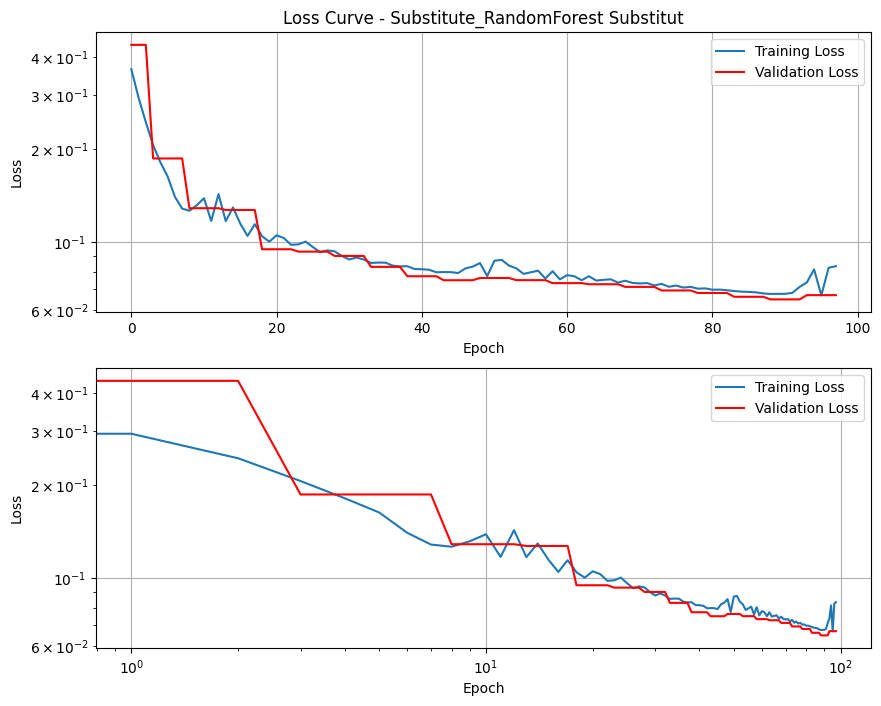

2025-11-27 18:44:21,532 - INFO - Running analysis for PyTorch model: Substitute_RandomForest Substitut on device: cuda:0
2025-11-27 18:44:22,322 - INFO - AUC: 0.9693


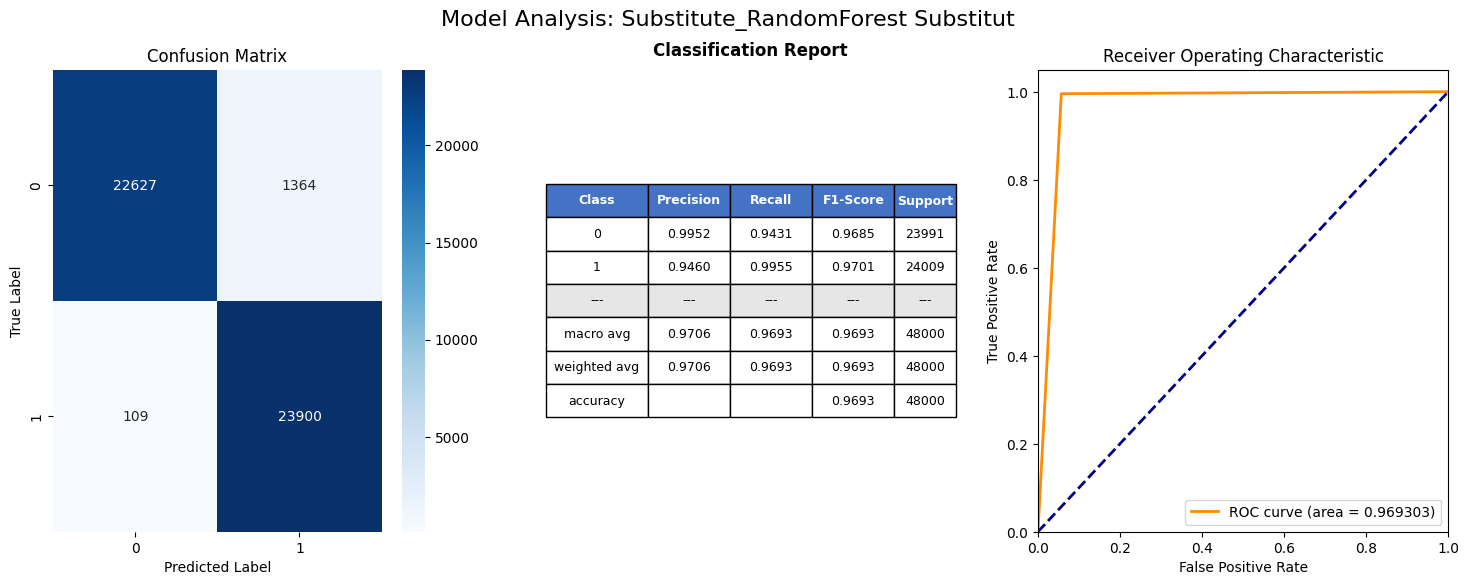

In [6]:
sub, cm, cr = attack_substitut(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    model_name="RandomForest Substitut",
    root_dir=root_dir,
    plot_analysis=True,
    plot_loss=True,
    save_fig=True,
    logger=lm.logger,
    device=device
)

Attack

In [7]:
x_adv = torch.FloatTensor(X_test).clone().detach().requires_grad_(True).to(device)
criterion = nn.CrossEntropyLoss()

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

x_adv = attack(
    model=sub,
    x_adv=x_adv,
    target=target,
    X_train=torch.FloatTensor(X_train),
    dataset=dataset,
    logger=logger,
    device=device
)

2025-11-27 18:44:22,959 - INFO - Initial prediction on adversarial input: [0 0 0 ... 1 1 0]
2025-11-27 18:44:28,590 - INFO - Successful adversarial example found at iteration 54
2025-11-27 18:44:28,594 - INFO - Adversarial input after 54 iterations: [0 0 0 ... 0 0 0]
2025-11-27 18:44:28,595 - INFO - Magnitude of perturbation:
2025-11-27 18:44:28,596 - INFO - Mean: 6598564.0
2025-11-27 18:44:28,597 - INFO - Min: 283.46875
2025-11-27 18:44:28,598 - INFO - Max: 5840253440.0
2025-11-27 18:44:28,600 - INFO - Std: 31703976.0


2025-11-27 18:44:28,663 - INFO - Running analysis for PyTorch model: RandomForest Substitut after adversarial attack on device: cuda
2025-11-27 18:44:32,588 - INFO - AUC: 0.5000


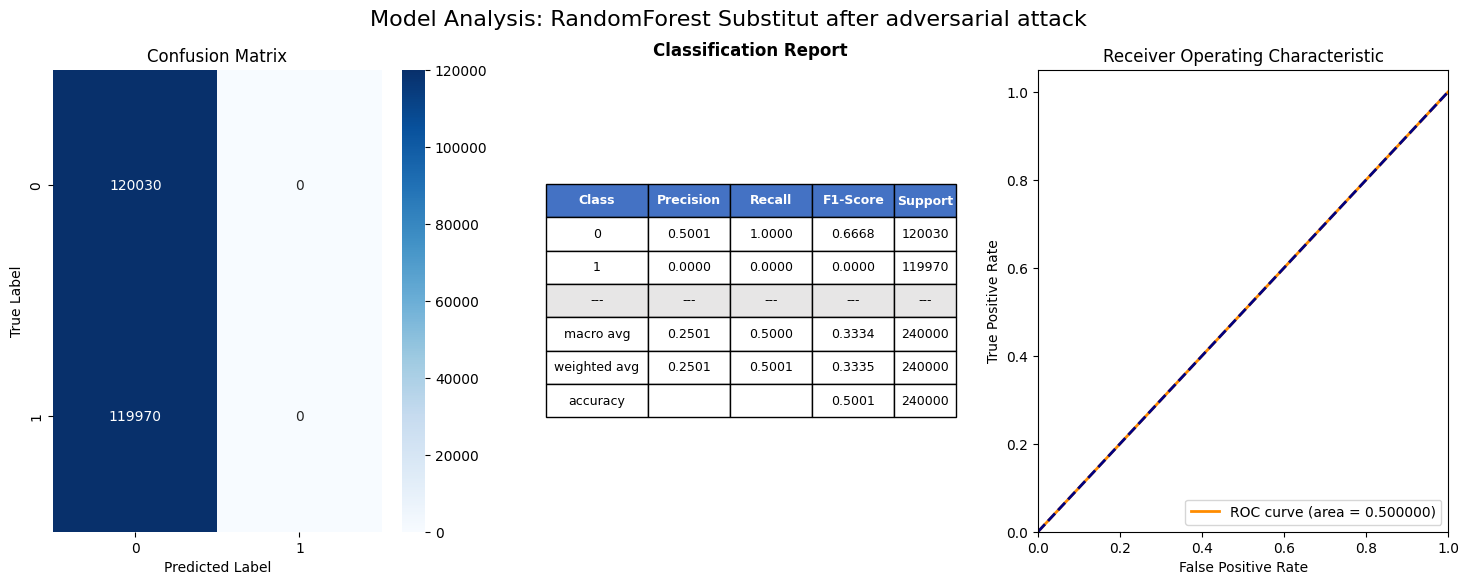

In [8]:
cm_rf, cr = perform_model_analysis(
    model=sub,
    X_test=x_adv,
    y_test=y_test,
    num_classes=num_classes,
    logger=logger,
    title="RandomForest Substitut after adversarial attack",
    root_dir=root_dir,
    plot=True
)

2025-11-27 18:44:33,086 - INFO - Running analysis for scikit-learn model: RandomForest after adversarial attack
2025-11-27 18:44:33,287 - INFO - AUC: 0.5774


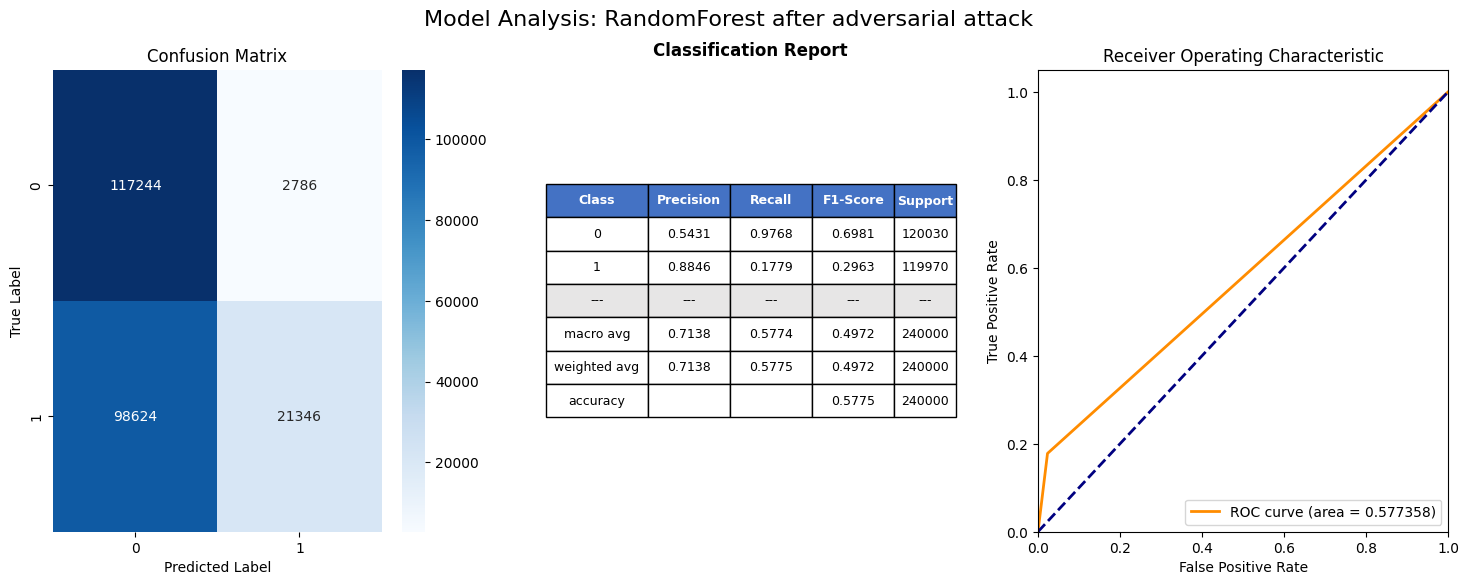

In [9]:
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=x_adv.cpu().numpy(),
    y_test=y_test,
    num_classes=num_classes,
    logger=logger,
    title="RandomForest after adversarial attack",
    root_dir=root_dir,
    plot=True
)

In [10]:
X_train, X_test_rob, y_train, y_test_rob = dataset.subset(size=800*1000, multi_class=multi_class).split(
    one_hot=True,
    test_size=0.2,
    apply_smote=True
)

X_train_rob = np.concatenate([X_train, x_adv.cpu().numpy()], axis=0)
y_train_rob = np.concatenate([y_train, y_test], axis=0)

2025-11-27 18:44:33,975 - INFO - Subsetting dataset to size: 800000...
2025-11-27 18:44:33,979 - INFO - Class distribution before subsetting:
2025-11-27 18:44:33,980 - INFO -   Class 0: 400000 samples
2025-11-27 18:44:33,980 - INFO -   Class 1: 400000 samples
2025-11-27 18:44:34,013 - INFO - Subsetted dataset to size: 800000
2025-11-27 18:44:34,342 - INFO - Splitting dataset into training and testing sets...
2025-11-27 18:44:38,990 - INFO - Class distribution before SMOTE:
2025-11-27 18:44:38,990 - INFO -   Class 0.0: 320184 samples
2025-11-27 18:44:38,999 - INFO -   Class 1.0: 319816 samples
2025-11-27 18:44:39,002 - INFO - Class distribution after SMOTE:
2025-11-27 18:44:39,002 - INFO -   Class 0.0: 320184 samples
2025-11-27 18:44:39,002 - INFO -   Class 1.0: 319816 samples


In [11]:
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model_robuste, cv_scores = train_random_forest(
    X_train_rob,
    y_train_rob,
    n_estimators=10,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)

if cv_scores != None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-27 18:44:39,154 - INFO - Training Random Forest with cross-validation using train_random_forest...


2025-11-27 18:45:24,109 - INFO - Running analysis for scikit-learn model: RandomForest Robust after adversarial training
2025-11-27 18:45:24,275 - INFO - AUC: 0.9867


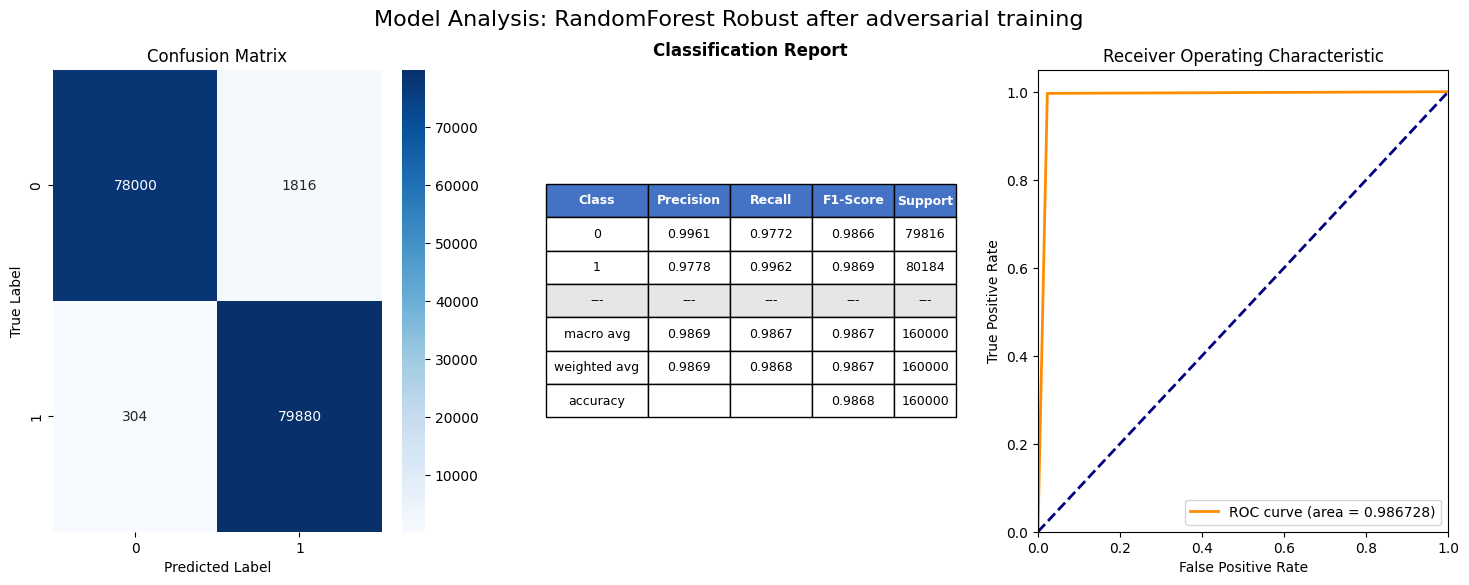

In [12]:
cm_rf, cr = perform_model_analysis(
    model=rf_model_robuste,
    X_test=X_test_rob,
    y_test=y_test_rob,
    num_classes=num_classes,
    logger=logger,
    title="RandomForest Robust after adversarial training",
    root_dir=root_dir,
    plot=True
)

2025-11-27 18:45:24,766 - INFO - Running analysis for scikit-learn model: RandomForest Robust Substitut
Loss: 0.0659, Val Loss: 0.0669, LR: 0.009000: 100%|██████████| 100/100 [02:58<00:00,  1.79s/it]
2025-11-27 18:48:24,049 - INFO - Plotting loss curve...
2025-11-27 18:48:24,704 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/results/loss_plots/Substitute_RandomForest Robust Substitut_loss.png


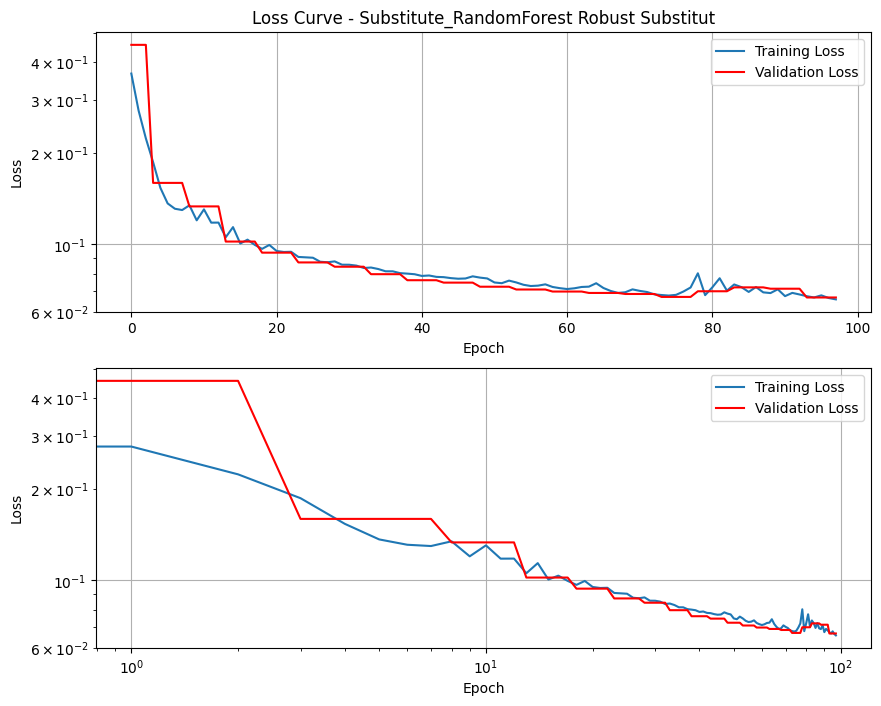

2025-11-27 18:48:24,910 - INFO - Running analysis for PyTorch model: Substitute_RandomForest Robust Substitut on device: cuda:0
2025-11-27 18:48:25,693 - INFO - AUC: 0.9760


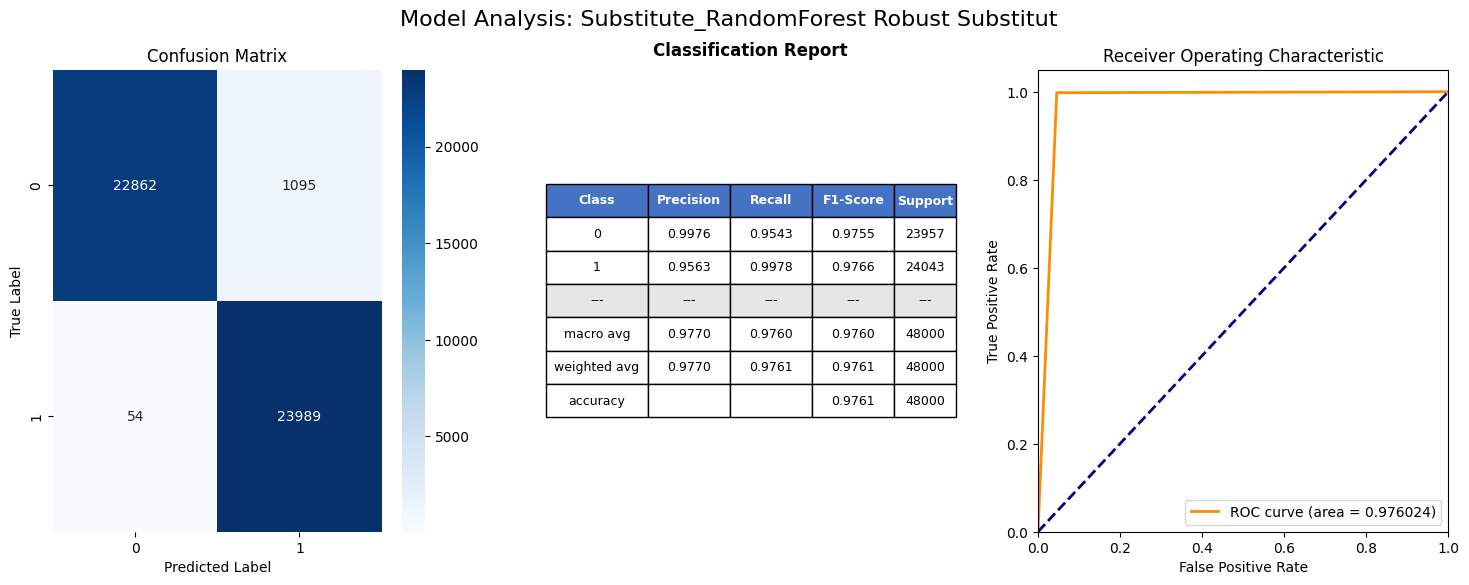

In [13]:
sub, cm, cr = attack_substitut(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    root_dir=root_dir,
    logger=lm.logger,
    model_name="RandomForest Robust Substitut",
    plot_analysis=True,
    plot_loss=True,
    save_fig=True,
    device=device
)

In [14]:
x_adv = torch.FloatTensor(X_test_rob).clone().detach().requires_grad_(True).to(device)
criterion = nn.CrossEntropyLoss()

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

x_adv = attack(
    model=sub,
    x_adv=x_adv,
    target=target,
    X_train=torch.FloatTensor(X_train_rob),
    dataset=dataset,
    logger=logger,
    device=device
)

2025-11-27 18:48:26,225 - INFO - Initial prediction on adversarial input: [1 1 1 ... 0 0 1]
2025-11-27 18:48:26,692 - INFO - Successful adversarial example found at iteration 3
2025-11-27 18:48:26,694 - INFO - Adversarial input after 3 iterations: [0 0 0 ... 0 0 0]
2025-11-27 18:48:26,695 - INFO - Magnitude of perturbation:
2025-11-27 18:48:26,697 - INFO - Mean: 2795165.0
2025-11-27 18:48:26,698 - INFO - Min: 7.558235168457031
2025-11-27 18:48:26,699 - INFO - Max: 2071000064.0
2025-11-27 18:48:26,700 - INFO - Std: 23129034.0


2025-11-27 18:48:26,734 - INFO - Running analysis for PyTorch model: RandomForest Robust Substitut after adversarial attack on device: cuda
2025-11-27 18:48:29,438 - INFO - AUC: 0.5000


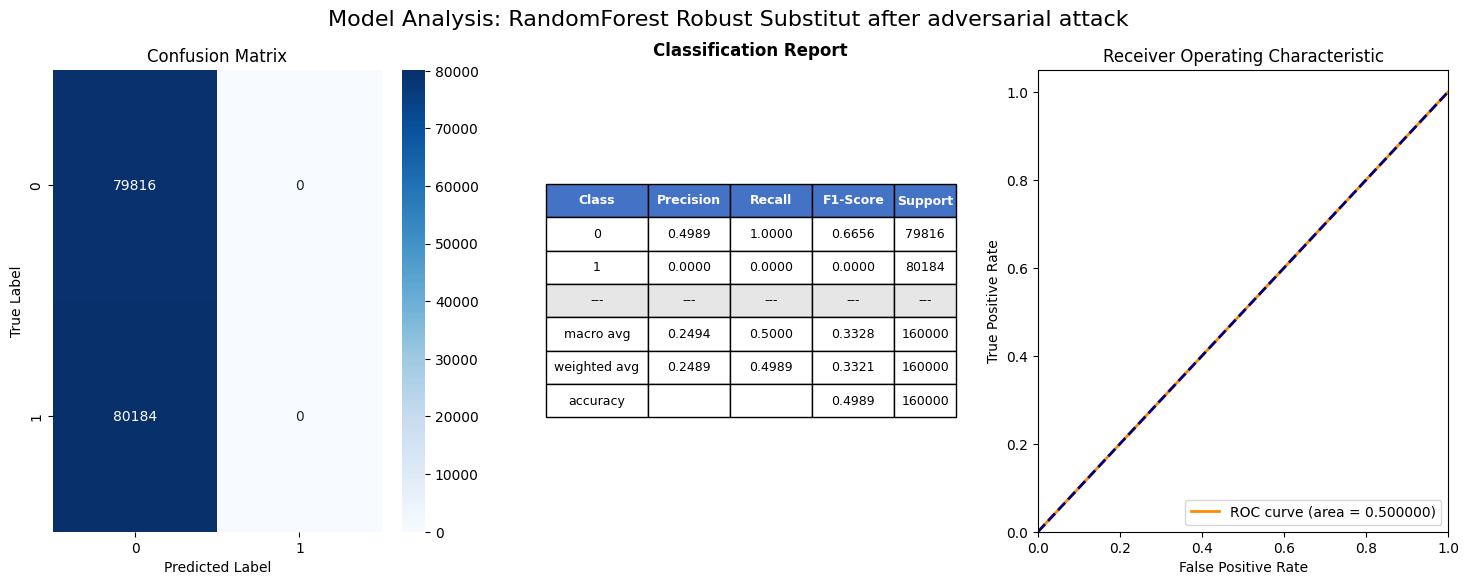

In [15]:
cm_rf, cr = perform_model_analysis(
    model=sub,
    X_test=x_adv,
    y_test=y_test_rob,
    num_classes=num_classes,
    logger=logger,
    title="RandomForest Robust Substitut after adversarial attack",
    root_dir=root_dir,
    plot=True
)

2025-11-27 18:48:29,964 - INFO - Running analysis for scikit-learn model: RandomForest Robust after adversarial attack
2025-11-27 18:48:30,111 - INFO - AUC: 0.8454


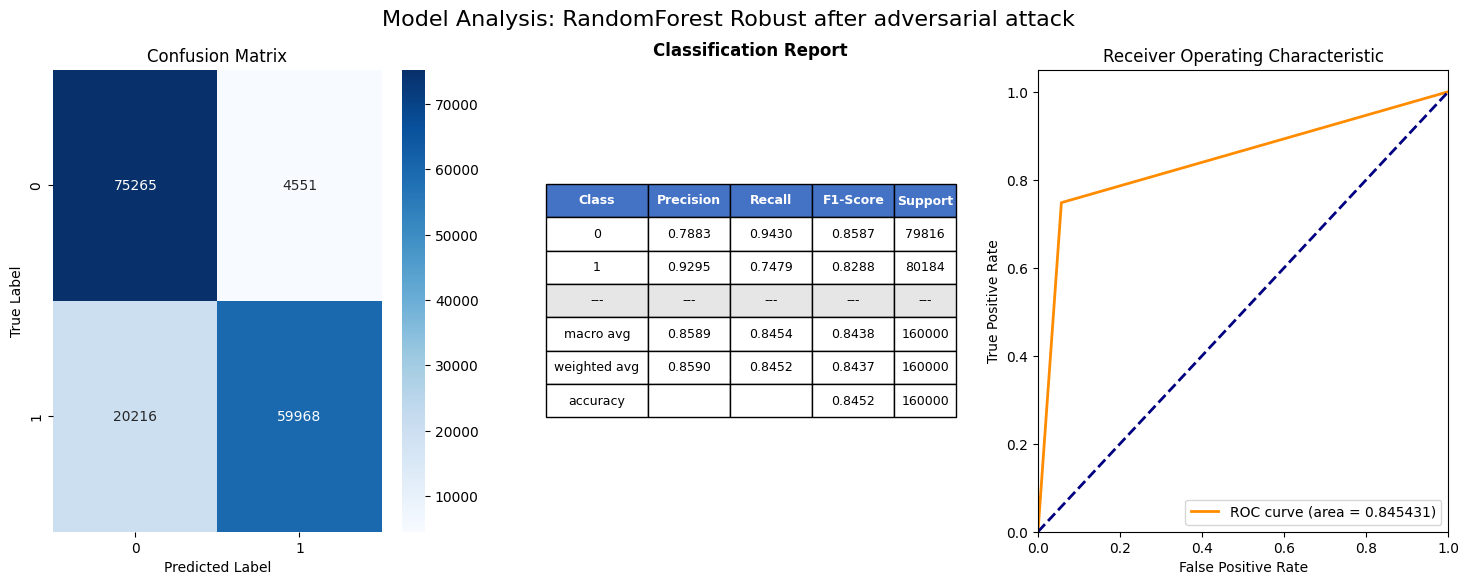

In [16]:
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=x_adv.cpu().numpy(),
    y_test=y_test_rob,
    num_classes= num_classes,
    logger=logger,
    title="RandomForest Robust after adversarial attack",
    root_dir=root_dir,
    plot=True
)